In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import xml.dom.minidom as minidom
import glob
import torch
import cv2
import os
import  xml.dom.minidom
import yaml
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader 

In [3]:
!pip install ultralytics
!pip install --upgrade ray
os.environ['WANDB_DISABLED']='true'
import ultralytics 
from ultralytics import YOLO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.6/873.6 kB 15.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 MB 18.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: ray
    Found existing installation: ray 2.5.1
    Uninstalling ray-2.5.1:
      Successfully uninstalled ray-2.5.1


First create a folder structure to organize our train, validation and test datasets:

In [4]:
# Create train, val and test paths

!rm -rf /kaggle/working/*

os.mkdir('/kaggle/working/images')
os.mkdir('/kaggle/working/labels')

os.mkdir('/kaggle/working/images/train')
os.mkdir('/kaggle/working/images/val')
os.mkdir('/kaggle/working/images/test')

os.mkdir('/kaggle/working/labels/train')
os.mkdir('/kaggle/working/labels/val')
os.mkdir('/kaggle/working/labels/test')

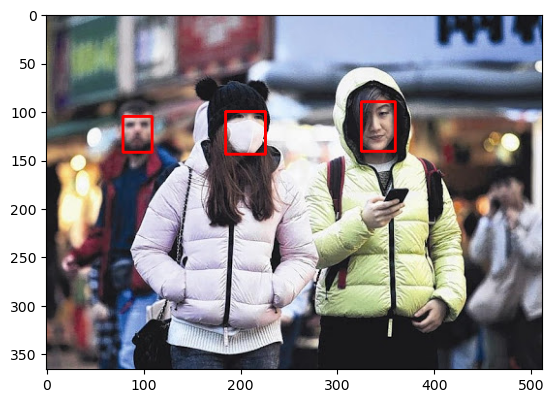

<?xml version="1.0" ?>
<annotation>
	
    
	<folder>images</folder>
	
    
	<filename>maksssksksss0.png</filename>
	
    
	<size>
		
        
		<width>512</width>
		
        
		<height>366</height>
		
        
		<depth>3</depth>
		
    
	</size>
	
    
	<segmented>0</segmented>
	
    
	<object>
		
        
		<name>without_mask</name>
		
        
		<pose>Unspecified</pose>
		
        
		<truncated>0</truncated>
		
        
		<occluded>0</occluded>
		
        
		<difficult>0</difficult>
		
        
		<bndbox>
			
            
			<xmin>79</xmin>
			
            
			<ymin>105</ymin>
			
            
			<xmax>109</xmax>
			
            
			<ymax>142</ymax>
			
        
		</bndbox>
		
    
	</object>
	
    
	<object>
		
        
		<name>with_mask</name>
		
        
		<pose>Unspecified</pose>
		
        
		<truncated>0</truncated>
		
        
		<occluded>0</occluded>
		
        
		<difficult>0</difficult>
		
        
		<bndbox>
			
            
			<xmin>185</xmin>
			
            
			<ymin>10

In [5]:
# Show sample image and print bounding boxes from the corresponding label

test_img = ski.io.imread('/kaggle/input/face-mask-detection/images/maksssksksss0.png')
test_label_path = '/kaggle/input/face-mask-detection/annotations/maksssksksss0.xml'

dom = xml.dom.minidom.parse(test_label_path)
root = dom.documentElement
objects = dom.getElementsByTagName("object")

coord_list = [
    [
        bndbox.getElementsByTagName('xmin')[0].childNodes[0].data,
        bndbox.getElementsByTagName('ymin')[0].childNodes[0].data,
        bndbox.getElementsByTagName('xmax')[0].childNodes[0].data,
        bndbox.getElementsByTagName('ymax')[0].childNodes[0].data
    ]
    for bndbox in root.getElementsByTagName('bndbox')
]

for coords in coord_list:
    cv2.rectangle(
        test_img, 
        (int(coords[0]), int(coords[1])),
        (int(coords[2]), int(coords[3])),
        (255, 0, 0),
        2
    )

plt.imshow(test_img), plt.show()


# Also show xml format of the label

print(dom.toprettyxml())

### The annotation format is currently in Pascal Voc xml, which is currently not suitable for YOLO. We have to convert the bounding boxes for txt format:

In [6]:
def to_yolo_format(bbox, w, h):
    """
    Converts the bounding box format into one suitable for YOLO.
    """
    w = int(w)
    h = int(h)
    bbox = list(map(int, bbox))
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2 ) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    
    return (x_center, y_center, width, height)

In [7]:
import shutil

def prepare_dataset(dataset_path, output_path, classes):
    
    images_path = os.path.join(dataset_path, 'images')
    annotations_path = os.path.join(dataset_path, 'annotations')
    
    images_files = ski.io.imread_collection(images_path + '/*').files 
    annotations_files = sorted(glob.glob(annotations_path))

    
    # Separate training, validation and test datasets
    train_val, test = train_test_split(images_files, test_size = .1, random_state = 42)
    train, val = train_test_split(train_val, test_size = .25, random_state = 42)
    
    
    for files, subset in [(train, 'train'), (val, 'val'), (test, 'test')]:
        
        for file in files:
            
            # Moving images
            img_destination = os.path.join(output_path, f'images/{subset}', os.path.basename(file))
            shutil.copy(file, img_destination)
            
            # Now taking care of annotations
            xml_basename = os.path.splitext(os.path.basename(file))[0] + '.xml'
            label_source = os.path.join(f'{dataset_path}/annotations', xml_basename)
            label_destination = os.path.join(
                output_path,
                f'labels/{subset}',
                os.path.splitext(xml_basename)[0] + '.txt'
            )
            
            # Convert the annotations to right format before exporting
            tree = xml.dom.minidom.parse(label_source)
            root = tree.documentElement
            size = tree.getElementsByTagName('size')[0]
            w = size.getElementsByTagName('width')[0].firstChild.data
            h = size.getElementsByTagName('height')[0].firstChild.data

            with open(label_destination, 'w') as out_label:
                for object in tree.getElementsByTagName('object'):
                    
                    name = object.getElementsByTagName('name')[0].childNodes[0].data
                    difficult = object.getElementsByTagName('difficult')[0].childNodes[0].data
                    if name not in classes or int(difficult) == 1:
                        continue
                    name_id = classes.index(name)
                    bndbox = object.getElementsByTagName('bndbox')[0]#.childNodes[0].data
                    bndbox_xmin = bndbox.getElementsByTagName('xmin')[0].childNodes[0].data
                    bndbox_ymin = bndbox.getElementsByTagName('ymin')[0].childNodes[0].data
                    bndbox_xmax = bndbox.getElementsByTagName('xmax')[0].childNodes[0].data
                    bndbox_ymax = bndbox.getElementsByTagName('ymax')[0].childNodes[0].data

                
                    formatted_box = to_yolo_format(
                        [bndbox_xmin, bndbox_ymin, bndbox_xmax, bndbox_ymax],
                        w, h
                    )
                
                    # We can finally export them
                    out_label.write(f"{name_id} {' '.join(map(str, formatted_box))}\n") 

In [8]:
classes = ['with_mask', 'without_mask', 'mask_weared_incorrect']
class_dict = {idx:classname for (idx, classname) in enumerate(classes)}

prepare_dataset(
    dataset_path = '/kaggle/input/face-mask-detection',
    output_path = '/kaggle/working/',
    classes = classes
)

To train Yolo we will create a yaml dataset file and specify it as input:

In [12]:
data_yaml = {
    'path': '/kaggle/working',
    'train': 'images/train',
    'val': 'images/val',
    'nc': len(classes),
    'names': class_dict
}

with open(os.path.join('/kaggle/working/', 'data.yaml'), 'w') as yaml_file:
    yaml.dump(data_yaml, yaml_file, default_flow_style = False)  

# Build and train model

In [13]:
model = YOLO('yolov8m.pt')
model.train(data='/kaggle/working/data.yaml', epochs = 60, batch = 32)

Ultralytics YOLOv8.2.98 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/kaggle/working/data.yaml, epochs=60, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True,

100%|██████████| 755k/755k [00:00<00:00, 38.6MB/s]
2024-09-20 18:03:14,126	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-20 18:03:14,618	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.25M/6.25M [00:00<00:00, 166MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/labels/train... 575 images, 0 backgrounds, 0 corrupt: 100%|██████████| 575/575 [00:01<00:00, 448.50it/s]

train: New cache created: /kaggle/working/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/labels/val... 192 images, 0 backgrounds, 0 corrupt: 100%|██████████| 192/192 [00:00<00:00, 523.51it/s]

val: New cache created: /kaggle/working/labels/val.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train2
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      14.8G        2.7      4.759      2.198        266        640:  28%|██▊       | 5/18 [00:07<00:17,  1.32s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       1/60      14.8G      2.472      4.221      2.017        316        640:  56%|█████▌    | 10/18 [00:12<00:09,  1.17s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       1/60      14.8G      2.061      3.194      1.689        352        640: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

                   all        192        827      0.654      0.408      0.362      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60        15G      1.214     0.9703      1.094        327        640: 100%|██████████| 18/18 [00:20<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

                   all        192        827      0.677      0.382      0.333      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      14.4G      1.208     0.9221      1.082        342        640: 100%|██████████| 18/18 [00:20<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all        192        827      0.449      0.402      0.175      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      14.5G      1.202     0.9055      1.146        238        640:  11%|█         | 2/18 [00:02<00:18,  1.17s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       4/60      14.5G       1.18     0.8572      1.087        321        640:  67%|██████▋   | 12/18 [00:13<00:06,  1.10s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       4/60      14.5G      1.168     0.8387      1.088        201        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

                   all        192        827      0.715      0.459      0.549      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      14.4G       1.18     0.7742      1.086        232        640:  72%|███████▏  | 13/18 [00:14<00:05,  1.07s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       5/60      14.4G       1.18      0.778      1.083        418        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]

                   all        192        827      0.572      0.438      0.431      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      14.9G      1.171     0.7859      1.092        245        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]

                   all        192        827     0.0248      0.183     0.0148    0.00778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60        15G      1.152     0.7428      1.093        229        640:  83%|████████▎ | 15/18 [00:16<00:03,  1.08s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       7/60        15G      1.165     0.7529      1.095        339        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

                   all        192        827      0.692      0.412      0.479      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60        15G      1.144     0.7216       1.08        223        640:  56%|█████▌    | 10/18 [00:11<00:08,  1.10s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       8/60        15G      1.149      0.722      1.084        200        640: 100%|██████████| 18/18 [00:19<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all        192        827      0.857      0.465      0.558      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60        15G      1.163     0.7394      1.081        344        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all        192        827      0.664      0.514       0.56      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60        15G      1.095      0.714       1.08        206        640:  39%|███▉      | 7/18 [00:07<00:11,  1.09s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      10/60        15G      1.119     0.7365      1.077        193        640:  94%|█████████▍| 17/18 [00:18<00:01,  1.10s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      10/60        15G      1.115      0.732      1.075        236        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all        192        827      0.723      0.536      0.639      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60        15G      1.104     0.6798      1.054        277        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]

                   all        192        827      0.808      0.545      0.682      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      14.4G      1.108     0.6953      1.054        181        640:  44%|████▍     | 8/18 [00:08<00:11,  1.11s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      12/60      14.4G       1.13      0.689      1.043        206        640: 100%|██████████| 18/18 [00:19<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all        192        827       0.71      0.663      0.693       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      14.4G      1.138     0.6845      1.046        343        640:  61%|██████    | 11/18 [00:12<00:07,  1.09s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      13/60      14.4G      1.125     0.6842      1.052        266        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]

                   all        192        827      0.832      0.731      0.798      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60        15G      1.084     0.6398      1.022        259        640:  56%|█████▌    | 10/18 [00:11<00:08,  1.12s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      14/60        15G      1.062     0.6327      1.015        307        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all        192        827      0.693      0.737      0.736      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      14.7G      1.074     0.6261      1.034        287        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all        192        827      0.839      0.716      0.773      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      14.5G      1.061      0.615      1.038        233        640: 100%|██████████| 18/18 [00:19<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all        192        827       0.86       0.75      0.834      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      14.9G      1.031     0.5974      1.025        266        640:  33%|███▎      | 6/18 [00:06<00:13,  1.10s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      17/60      14.9G      1.018     0.5879       1.03        235        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all        192        827      0.845      0.728      0.787      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      14.9G      1.027     0.5842      1.035        154        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all        192        827      0.904      0.802      0.827      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      14.9G      1.036     0.5655      1.025        271        640:  22%|██▏       | 4/18 [00:04<00:15,  1.12s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      19/60      14.9G       1.03     0.5688      1.024        317        640: 100%|██████████| 18/18 [00:19<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all        192        827      0.826      0.674      0.725      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60        15G      1.064     0.6126      1.018        348        640:  44%|████▍     | 8/18 [00:09<00:11,  1.12s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      20/60        15G      1.058     0.6021      1.021        232        640:  83%|████████▎ | 15/18 [00:16<00:03,  1.09s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      20/60        15G      1.056     0.5991       1.02        235        640: 100%|██████████| 18/18 [00:19<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all        192        827      0.872      0.805      0.821      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60        15G      1.016     0.5559       1.01        285        640: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

                   all        192        827      0.845       0.79      0.841      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      14.8G      1.017      0.551      1.005        242        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all        192        827      0.866      0.739      0.801      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      14.7G     0.9914      0.548     0.9912        263        640:  67%|██████▋   | 12/18 [00:13<00:06,  1.09s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      23/60      14.7G     0.9982     0.5481     0.9961        265        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all        192        827      0.904      0.826      0.858      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60        15G     0.9986     0.5442     0.9926        277        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all        192        827      0.929      0.785      0.857      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60        15G     0.9318     0.5045     0.9968        155        640:  28%|██▊       | 5/18 [00:05<00:14,  1.11s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      25/60        15G     0.9337     0.5059     0.9886        208        640:  56%|█████▌    | 10/18 [00:11<00:08,  1.09s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      25/60        15G     0.9387     0.5079     0.9905        179        640: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

                   all        192        827      0.868      0.806      0.822      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      14.7G     0.9805     0.5394      1.004        139        640:  78%|███████▊  | 14/18 [00:15<00:04,  1.11s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      26/60      14.7G     0.9814      0.538      1.001        247        640: 100%|██████████| 18/18 [00:19<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all        192        827      0.875       0.79      0.843      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60        15G      1.012     0.5342     0.9982        270        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all        192        827      0.836      0.816      0.862       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      14.4G     0.9409      0.499      1.008        239        640:  39%|███▉      | 7/18 [00:07<00:12,  1.11s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      28/60      14.4G      0.947     0.5128     0.9963        251        640: 100%|██████████| 18/18 [00:19<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all        192        827      0.898      0.702      0.805      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      14.9G     0.9903     0.5092     0.9741        282        640:  33%|███▎      | 6/18 [00:06<00:13,  1.11s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      29/60      14.9G     0.9564     0.5043     0.9795        188        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all        192        827      0.896      0.759      0.853      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      14.5G     0.9431     0.4815     0.9704        300        640: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]

                   all        192        827      0.898      0.781      0.872      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      14.5G     0.9226     0.4918     0.9734        196        640:  50%|█████     | 9/18 [00:09<00:09,  1.08s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      31/60      14.5G     0.9238     0.4865     0.9759        279        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all        192        827      0.923       0.83      0.866      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      14.9G     0.9129     0.4769      0.966        201        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all        192        827      0.954      0.792       0.87      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      14.5G     0.9123     0.4837     0.9843        205        640:  17%|█▋        | 3/18 [00:03<00:16,  1.10s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      33/60      14.5G     0.9083     0.4809     0.9697        208        640: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all        192        827       0.95      0.805      0.872      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      14.9G     0.9041      0.481     0.9542        411        640:  33%|███▎      | 6/18 [00:06<00:13,  1.11s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      34/60      14.9G     0.8913      0.472     0.9603        215        640: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all        192        827      0.922      0.816      0.883       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      14.9G     0.8895     0.4576     0.9566        278        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all        192        827      0.929      0.763      0.881      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      14.4G     0.9204     0.4705     0.9585        342        640:  50%|█████     | 9/18 [00:10<00:09,  1.10s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      36/60      14.4G     0.8993     0.4654     0.9582        386        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all        192        827      0.942      0.789      0.858      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      14.4G     0.8512     0.4397     0.9521        220        640:  33%|███▎      | 6/18 [00:06<00:13,  1.10s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      37/60      14.4G     0.8705     0.4469     0.9467        396        640:  67%|██████▋   | 12/18 [00:13<00:06,  1.10s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      37/60      14.4G     0.8772     0.4478     0.9503        277        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all        192        827      0.913      0.797      0.869      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      14.9G     0.8494     0.4359     0.9429        184        640: 100%|██████████| 18/18 [00:19<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all        192        827      0.846      0.817      0.862      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60        15G     0.8463     0.4441     0.9468        276        640: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all        192        827      0.941      0.779      0.872      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60        15G      0.861     0.4384     0.9508        242        640:  56%|█████▌    | 10/18 [00:10<00:08,  1.09s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      40/60        15G     0.8552     0.4365     0.9509        246        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

                   all        192        827      0.943      0.791       0.87      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      14.9G      0.855     0.4273     0.9462        268        640: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all        192        827      0.948      0.811      0.875       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      14.4G     0.8589     0.4382     0.9307        276        640:  44%|████▍     | 8/18 [00:08<00:10,  1.10s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      42/60      14.4G     0.8612     0.4306      0.943        241        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all        192        827       0.92      0.819      0.887      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      14.4G     0.8191      0.417     0.9462        313        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all        192        827      0.914      0.812      0.876      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60        15G     0.8254     0.4099      0.932        214        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]

                   all        192        827       0.88      0.808       0.88       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      14.9G     0.8178     0.4201     0.9472        209        640:  17%|█▋        | 3/18 [00:03<00:16,  1.10s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      45/60      14.9G     0.7746      0.396     0.9312        206        640:  67%|██████▋   | 12/18 [00:13<00:06,  1.09s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      45/60      14.9G     0.7924     0.4009     0.9286        281        640: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]

                   all        192        827      0.865      0.786      0.865      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      14.9G     0.8221     0.4091     0.9392        255        640:  89%|████████▉ | 16/18 [00:17<00:02,  1.09s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      46/60      14.9G     0.8193     0.4076     0.9373        213        640: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all        192        827      0.932      0.812      0.878      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60        15G     0.8167     0.4036     0.9283        259        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all        192        827      0.925      0.797       0.88      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      14.8G     0.7791     0.3992     0.9239        274        640:  94%|█████████▍| 17/18 [00:18<00:01,  1.09s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      48/60      14.8G     0.7742     0.3974     0.9218        251        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all        192        827      0.899      0.819      0.885      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      14.4G     0.7626     0.3863     0.9175        234        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all        192        827      0.929      0.809      0.885       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60        15G     0.7911     0.3924     0.9331        316        640:  22%|██▏       | 4/18 [00:04<00:15,  1.12s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      50/60        15G     0.7758     0.3869     0.9156        277        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all        192        827      0.914      0.807      0.883      0.621


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/18 [00:00<?, ?it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      51/60        15G     0.7602     0.3721     0.9181        137        640:  94%|█████████▍| 17/18 [00:21<00:01,  1.10s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      51/60        15G     0.7578     0.3709     0.9185        131        640: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all        192        827      0.958       0.79      0.881      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60        15G     0.7585     0.3613     0.9269        110        640: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

                   all        192        827       0.89      0.816       0.85      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60        15G      0.733     0.3405     0.9008         86        640:  61%|██████    | 11/18 [00:12<00:07,  1.10s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      53/60        15G     0.7432     0.3468     0.9033        112        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all        192        827       0.93      0.798      0.875      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      14.9G     0.7427     0.3479     0.9166         89        640: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all        192        827      0.911      0.811      0.869      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60        15G     0.7085       0.33      0.905        117        640: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all        192        827      0.906      0.818       0.88      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60        15G     0.6944     0.3211     0.9003        111        640: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all        192        827      0.885      0.831      0.879      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      14.4G     0.7541     0.3407     0.9096        194        640:  33%|███▎      | 6/18 [00:06<00:13,  1.11s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      57/60      14.4G     0.7114     0.3267     0.9091        131        640:  67%|██████▋   | 12/18 [00:13<00:06,  1.10s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      57/60      14.4G     0.7043     0.3269     0.9009        104        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all        192        827      0.906      0.832      0.876       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60        15G     0.6758     0.3194     0.8976         99        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

                   all        192        827      0.915      0.821      0.878      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60        15G     0.6871     0.3192     0.8927        156        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all        192        827      0.911      0.821      0.882      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      14.5G     0.6976     0.3286     0.8924        251        640:  39%|███▉      | 7/18 [00:07<00:11,  1.09s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      60/60      14.5G     0.6716     0.3149     0.8857        190        640: 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all        192        827      0.913       0.82      0.879      0.615



60 epochs completed in 0.401 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 52.0MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.2.98 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


                   all        192        827      0.941       0.78      0.872      0.629
             with_mask        178        704      0.951      0.908      0.966      0.683
          without_mask         57        107      0.961      0.682      0.854      0.556
 mask_weared_incorrect         15         16       0.91       0.75      0.797      0.647
Speed: 2.1ms preprocess, 8.8ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train2


lr/pg0,▂▄▆▇███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁
lr/pg1,▂▄▆▇███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁
lr/pg2,▂▄▆▇███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁
metrics/mAP50(B),▁▁▄▂▃▄▅▅▇▆▇▇▆▇▇█▇▇▇█████████████████████
metrics/mAP50-95(B),▁▁▄▂▂▃▅▅▆▅▇▇▆▇▇▇▇▇▆▇██████████████▇█████
metrics/precision(B),▃▃▄▁▃▆▄▅▆▃▆▆▆▆▆▇▆▇▇▇▇█▇█▇▆██▇▇█▇█▇▇█▇▇▇█
metrics/recall(B),▁▁▂▂▁▂▃▄▆▇▇▆▆█▇██▇▆▇█▇█▇▇█▇████▇███▇███▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▄▃▄▃▃▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d605131c640>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

## Testing the model

/kaggle/working/images/test/maksssksksss412.png

image 1/1 /kaggle/working/images/test/maksssksksss412.png: 640x640 4 with_masks, 42.5ms
Speed: 2.8ms preprocess, 42.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


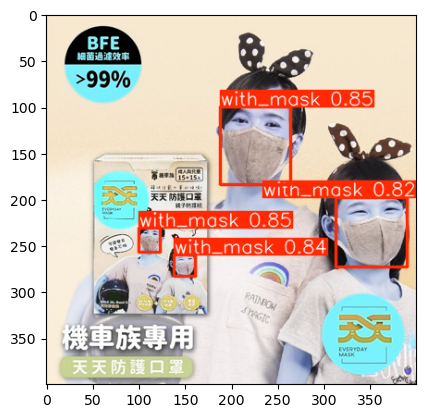

/kaggle/working/images/test/maksssksksss424.png

image 1/1 /kaggle/working/images/test/maksssksksss424.png: 448x640 27 with_masks, 3 without_masks, 1 mask_weared_incorrect, 15.9ms
Speed: 2.4ms preprocess, 15.9ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


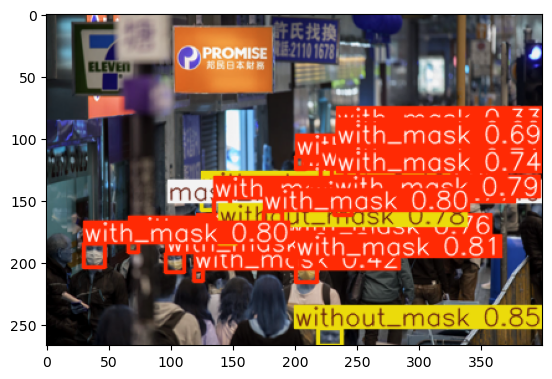

/kaggle/working/images/test/maksssksksss558.png

image 1/1 /kaggle/working/images/test/maksssksksss558.png: 384x640 16 with_masks, 4 without_masks, 12.9ms
Speed: 1.8ms preprocess, 12.9ms inference, 29.7ms postprocess per image at shape (1, 3, 384, 640)


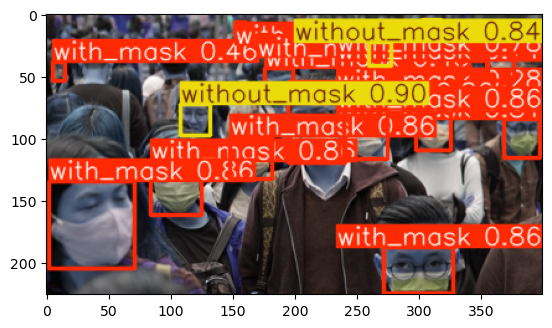

/kaggle/working/images/test/maksssksksss78.png

image 1/1 /kaggle/working/images/test/maksssksksss78.png: 640x512 1 with_mask, 38.4ms
Speed: 2.2ms preprocess, 38.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


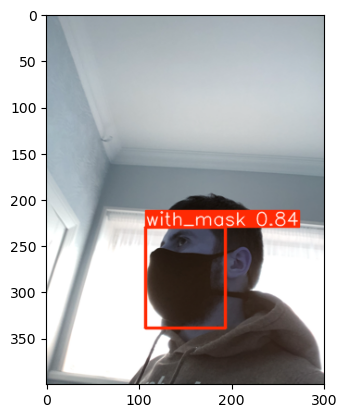

/kaggle/working/images/test/maksssksksss86.png

image 1/1 /kaggle/working/images/test/maksssksksss86.png: 480x640 2 with_masks, 1 without_mask, 37.7ms
Speed: 2.0ms preprocess, 37.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


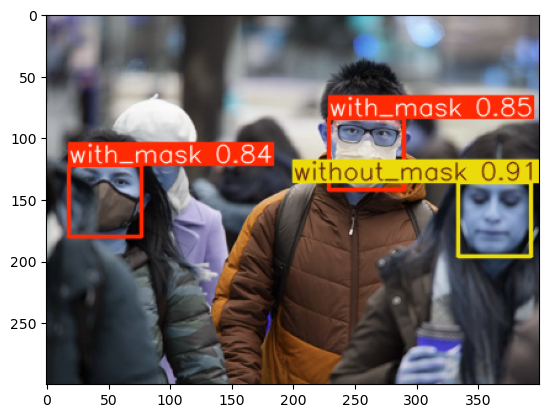

/kaggle/working/images/test/maksssksksss514.png

image 1/1 /kaggle/working/images/test/maksssksksss514.png: 448x640 7 with_masks, 2 without_masks, 3 mask_weared_incorrects, 40.1ms
Speed: 2.0ms preprocess, 40.1ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


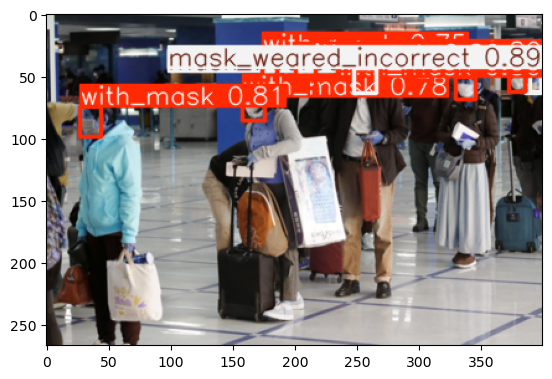

In [21]:
for test_img in ['/kaggle/working/images/test/maksssksksss412.png', 
                 '/kaggle/working/images/test/maksssksksss424.png', 
                 '/kaggle/working/images/test/maksssksksss558.png',
                 '/kaggle/working/images/test/maksssksksss78.png', 
                 '/kaggle/working/images/test/maksssksksss86.png',
                 '/kaggle/working/images/test/maksssksksss514.png']:
    
    print(test_img)
    res = model.predict(test_img)
    plt.imshow(res[0].plot()), plt.show()